In [1]:
import pandas as pd # csv 파일 읽기 위함
import numpy as np  # 행렬 연산을 위함
import matplotlib.pyplot as plt     # 데이터 시각화 위함
from keras.models import Sequential # 딥러닝 모델 작성
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset

In [2]:
# csv 읽어오기
data = pd.read_csv('data/005930.KS.csv')
data.head() # 데이터 프레임의 맨앞 5줄 데이터 출력

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-08,38740.0,38780.0,38200.0,38400.0,33323.398438,17092950
1,2017-02-09,38780.0,38840.0,38220.0,38400.0,33323.398438,13694150
2,2017-02-10,38400.0,38760.0,38300.0,38360.0,33288.699219,11020750
3,2017-02-13,37740.0,38060.0,37720.0,37960.0,32941.574219,11102050
4,2017-02-14,37960.0,38260.0,37320.0,37580.0,32611.814453,13124150


# Compute Mid Price

In [3]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2 # 중간 가격 저장 (중간 가격 예측을 위함)

# Create Windows

In [4]:
# Window 만들기
# LSTM의 기본 개념 - 최근 50일 동안의 데이터를 보고 내일 가격을 예측
seq_len = 50 # --> window (변경 가능)
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])
    # 51개씩 한 스텝씩 넘어가면서 result에 저장 (--> window 만든것)

# Normalize Data

In [5]:
# 정규화 - 모델이 좀 더 예측을 잘 하기 위함
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train(90%) and test(10%) data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)
# train set을 랜덤으로 섞음
# 데이터가 순서대로 들어가게 되면 모델이 익숙해지기 때문에 섞어주는 것이 좋음

x_train = train[:, :-1] # 앞에서 부터 50개
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1] # 맨 뒤 1개

x_test = result[row:, :-1] # 50개
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1] # 1개

x_train.shape, x_test.shape
# 1057개의 train set과 117개의 test set
# = 1057일의 data로 학습을 해서 117일의 주식 가격을 예측한다.

((1057, 50, 1), (117, 50, 1))

# Build a Model

In [6]:
model = Sequential() # 모델을 순차적으로 정의하는 클래스

# keras.layers.LSTM(): LSTM 레이어
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

# loss function: mse / oprimizer: RMSProp
model.compile(loss='mse', optimizer='rmsprop')

# 모델의 개요 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
# model.fit(): 모델을 학습 시킴
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 9s 46ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 2/20
106/106 [==============================] - 4s 33ms/step - loss: 0.0012 - val_loss: 5.2116e-04
Epoch 3/20
106/106 [==============================] - 3s 31ms/step - loss: 8.2441e-04 - val_loss: 0.0011
Epoch 4/20
106/106 [==============================] - 5s 47ms/step - loss: 6.2220e-04 - val_loss: 2.4502e-04
Epoch 5/20
106/106 [==============================] - 4s 41ms/step - loss: 5.4590e-04 - val_loss: 2.0461e-04
Epoch 6/20
106/106 [==============================] - 4s 39ms/step - loss: 4.3251e-04 - val_loss: 1.8728e-04
Epoch 7/20
106/106 [==============================] - 4s 39ms/step - loss: 3.9267e-04 - val_loss: 2.8324e-04
Epoch 8/20
106/106 [==============================] - 4s 39ms/step - loss: 3.6352e-04 - val_loss: 2.4643e-04
Epoch 9/20
106/106 [==============================] - 4s 39ms/step - loss: 3.2547e-04 - val_loss: 1.7365e-04
Epoch 10/20
106/106 [==============

# Prediction

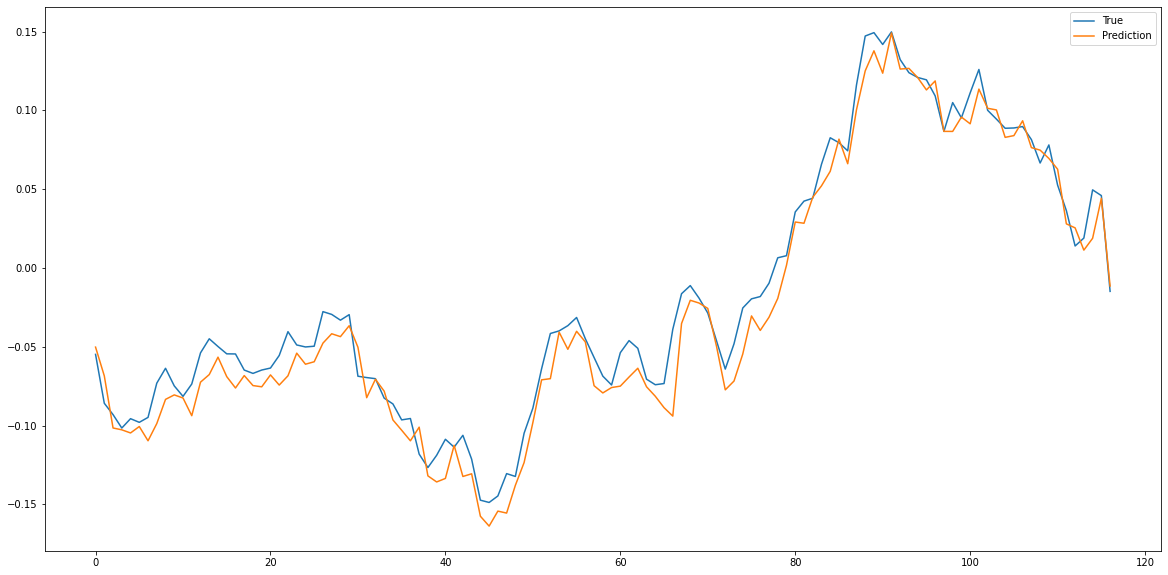

In [8]:
# model.predict(): 모델을 사용하여 test data를 예측함
pred = model.predict(x_test)

# 그래프 그리기 (50일 간의 데이터로 하루를 예측한 결과)
# 파란색: 실제 데이터, 주황색: 예측 데이터
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()